In [ ]:
# default_exp metrics

# metrics

> API details.

In [ ]:
#export
#hide
import numpy as np
import scipy.stats
import torch
from scipy.stats import chi2 as Chi2Dist
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from fastcore.test import *
from fastai.metrics import rmse
import dcor

In [ ]:
#export
def crps_for_quantiles(probabilistic_forecasts, measurements, quantiles=np.linspace(0.1, 0.9, 9)):
    """ Computes the CRPS score with quantile representation.
        This variant is the variant proposed in Hersbach H. Decomposition of the Continuous Ranked Probability Score for
        Ensemble Prediction Systems. Weather Forecast. 2000;15(5):559-570.
        Parameters
        ----------
            probabilistic_forecasts: array_like
               Either list of "M" scipy.stats.rv_continuous distributions
               https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html
               OR
               2D-numpy array with quantile forecasts with dimensionality M x Q,
               where "Q" is number of quantiles.
            measurements: array_like
               List or numpy array with "M" measurements / observations.
            quantiles: array_like
               List of "Q" values of the quantiles to be evaluated.
        Returns
        -------
            mean_crps: float
                The mean CRIGN over all probabilistic_forecast - measurement pairs.
            single_crps: array, shape (M,)
                CRIGN value for each probabilistic_forecast - measurement pair.
    """

    quantile_forecasts = np.array(probabilistic_forecasts)

    measurements = np.atleast_2d(measurements).T

    alpha_mat = np.diff(np.hstack([quantile_forecasts, measurements]))
    alpha_mat = np.maximum(0, alpha_mat)
    alpha_mat = np.minimum(alpha_mat, np.maximum(0, np.repeat(measurements, quantile_forecasts.shape[1],
                                                              axis=1) - quantile_forecasts))

    beta_mat = np.diff(np.hstack([measurements, quantile_forecasts]))
    beta_mat = np.maximum(0, beta_mat)
    beta_mat = np.minimum(beta_mat,
                          np.maximum(0,
                                     quantile_forecasts - np.repeat(measurements, quantile_forecasts.shape[1], axis=1)))

    single_crps = np.matmul(alpha_mat, np.power(quantiles, 2)) + np.matmul(beta_mat, np.power(quantiles - 1, 2))

    return np.mean(single_crps), single_crps

In [ ]:
quantiles = np.array([0.25,0.5, 0.75])
probabilistic_forecasts = np.array([[1,2,3],[4,5,6],[7,8,9],])
measurements = np.array([2,5,8])

In [ ]:
mean_crps, crps_per_observation = crps_for_quantiles(probabilistic_forecasts, measurements, quantiles)
mean_crps

0.125

In [ ]:
#export 
def rmse_nll(preds, targs, pos_mean=0):
    """RMSE for negative log likelihood forecast, where we have e.g. the mean and the variance as prediction."""
    return rmse(preds[:, pos_mean], targs)

In [ ]:
#export
def normalized_sum_of_squared_residuals_np(stochastic_preds, targets):
    """
        Calculates normalized sof of squared residuals according to Eq. 50-52 in https://arxiv.org/pdf/2007.06823.pdf 
        stochastic samples of shape [n_observation, n_targets, n_samples]
        targets of shape [n_observation, n_targets]
    """
    nruntests = len(stochastic_preds)
    predictions = stochastic_preds.mean(axis=-1, keepdims=True)
    errors = targets - predictions.squeeze(-1)
    covs = stochastic_preds-predictions
    
    covs = (covs @ covs.swapaxes(1,2)) / (nruntests-1.)
    
    
    weights = np.linalg.inv(covs)
    nssr = np.matmul(errors[:,np.newaxis,:], np.matmul(weights, errors[:,:,np.newaxis]))
   
    nssr = np.sort(nssr.flatten())
    
    p_prediction = Chi2Dist.cdf(nssr, targets.shape[1]);
    p_expected = np.linspace(1./nssr.size, 1.0, nssr.size)
    
    return p_prediction, p_expected

In [ ]:
stochasic_preds = np.array([[1.01,2.05,3.04], [3.05,2.02,1.01]]).reshape(3,1,2)
targets = np.array([2.1,2.05,2.2]).reshape(3,1,1)
stochasic_preds.shape, targets.shape

((3, 1, 2), (3, 1, 1))

In [ ]:
p_prediction_np, p_expected_np = normalized_sum_of_squared_residuals_np(stochasic_preds, targets)

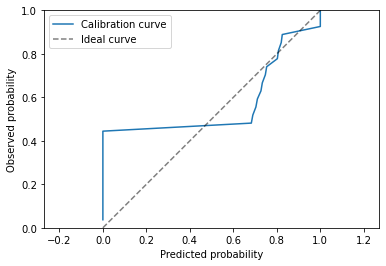

In [ ]:
plt.figure("Calibration curve for sparse measure model")
plt.plot(p_prediction_np, p_expected_np, label='Calibration curve')
plt.plot([0,1],[0,1], 'k--', alpha=0.5, label='Ideal curve')
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.axis('equal')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()

plt.show()

The result can be utilized to calculate the area under the curve

In [ ]:
auc(p_expected_np, p_prediction_np)

0.4260104080499696

Or the distance to the ideal curve

In [ ]:
#export
def distance_ideal_curve(p_prediction, p_expected):
    return np.trapz((p_prediction-p_expected)**2)**0.5

In [ ]:
distance_ideal_curve(p_expected_np, p_prediction_np)

1.0124797387874436

In [ ]:
#export
def normalized_sum_of_squared_residuals_torch(stochastic_preds, targets):
    """
        Calculates normalized sof of squared residuals according to Eq. 50-52 in https://arxiv.org/pdf/2007.06823.pdf 
        stochastic samples of shape [n_observation, n_targets, n_samples]
        targets of shape [n_observation, n_targets]
    """
    
    predictions = stochastic_preds.mean(axis=-1, keepdim=True)
    errors = targets - predictions.squeeze(dim=-1)
    nruntests = len(stochastic_preds)
    predictions = stochastic_preds.mean(axis=-1, keepdims=True)
    covs = stochastic_preds - predictions
    
    covs = torch.matmul(covs, torch.transpose(covs, 1, 2))/(nruntests-1.)
    
    
    weights = torch.linalg.inv(covs) #
    nssr = torch.matmul(errors[:,np.newaxis,:].float(), 
                    torch.matmul(weights.float(), errors[:,:,np.newaxis].float()).float() )
    
    nssr = nssr.cpu().numpy().flatten()
    nssr = np.sort(nssr)
    
    p_prediction = Chi2Dist.cdf(nssr, targets.shape[1]);
    p_expected = np.linspace(1./nssr.size, 1.0, nssr.size)
    
    return p_prediction, p_expected

In [ ]:
p_prediction_torch, p_expected_torch = normalized_sum_of_squared_residuals_torch(torch.tensor(stochasic_preds),torch.tensor( targets))

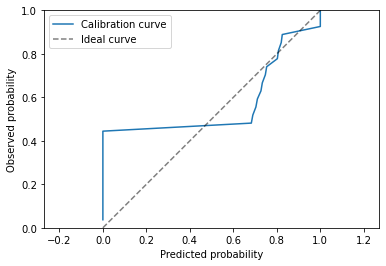

In [ ]:
plt.figure("Calibration curve for sparse measure model")
plt.plot(p_prediction_torch, p_expected_torch, label='Calibration curve')
plt.plot([0,1],[0,1], 'k--', alpha=0.5, label='Ideal curve')
plt.xlabel('Predicted probability')
plt.ylabel('Observed probability')
plt.axis('equal')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()

plt.show()

In [ ]:
#hide
test_close(p_expected_np, p_expected_torch)
test_close(p_prediction_np, p_prediction_torch)

In [ ]:
auc(p_expected_torch, p_prediction_torch)

0.42601040751471086

In [ ]:
distance_ideal_curve(p_expected_torch, p_prediction_torch)

1.0124797346001766

In [ ]:
#export
def energy_distance(samples, targets):
    """
        samples tensor (e.g. from a Bayesian Model) of shape [n_observation, n_samples]
        target tensor observatrion fo shape [n_observation, 1]
    """
    return dcor.energy_distance(samples.reshape(samples.shape[0], samples.shape[-1]).T, targets.T)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00a_utils.ipynb.
Converted 00b_losses.ipynb.
Converted 00c_utils_blitz.ipynb.
Converted 00d_baselines.ipynb.
Converted 00e_metrics.ipynb.
Converted 00f_utils_pytorch.ipynb.
Converted 01_tabular.core.ipynb.
Converted 02_tabular.data.ipynb.
Converted 03_tabular.model.ipynb.
Converted 04_tabular.learner.ipynb.
Converted 05_timeseries.core.ipynb.
Converted 06_timeseries.data.ipynb.
Converted 07_timeseries.model.ipynb.
Converted 08_timeseries.learner.ipynb.
Converted 09_gan.core.ipynb.
Converted 10_autoencoder_models.ipynb.
Converted 11_probabilistic_models.ipynb.
Converted index.ipynb.
